## Invoke deployed model endpoint and predict on new wells that are in S3 input data

In [ ]:
# Inputs required 

# Deployed model endpoint name
ep_name = 'mlendpoint25Jan2022'

# Bucket name with well-logs for prediction 
bucket_wells_pred = 'inputdata-vishalab3'

# Subdirectory name where the well-logs are located 
sub_directory = 'new_wells/'

# Bucket name for storing predicted results
bucket_wells_mlresults = 'mlresults-facies'

# Subdirectory name in mlresults bucket
sub_directory_mlresults = 'predicted_wells/'

In [3]:
%%time
import boto3, sys
sm_rt = boto3.Session().client('runtime.sagemaker')
import pandas as pd
# well_name= 'CROSS H CATTLE'
num_features = 10

s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket_wells_pred)

for object_summary in my_bucket.objects.filter(Prefix=sub_directory):
    if object_summary.key.endswith('csv'):
        file_name = object_summary.key
        well_name = file_name.split('/')[1].split('.csv')[0]
        orig_file = sub_directory + well_name +'.csv'
        dest_file = './' + well_name +'.csv'
        s3.Bucket(bucket_wells_pred).download_file(orig_file, dest_file)

        with open(well_name + '.csv') as f:
            lines = f.readlines()
            response_final = []
            label = []
            for l in lines[1:]:   # Skip header
                l = l.split(',')      # Split CSV line into features
                label.append(l[0])         # Store labels
                l = l[1:num_features]            # Remove label
                l = ','.join(l)       # Rebuild CSV line without label

                response = sm_rt.invoke_endpoint(EndpointName=ep_name, 
                                                 ContentType='text/csv',       
                                                 Accept='text/csv', Body=l)

                response = response['Body'].read().decode("utf-8")
                response_final.append(response[0])

        label = [int(i) for i in label]
        response_final = [int(i) for i in response_final]
        
        
        df = pd.read_csv(well_name + '.csv')
        df['pred_facies'] = response_final
        df['Well_name'] = well_name
        

        pred_file = well_name + '_pred.csv';
        df.to_csv(pred_file, index=False, header=True)
        
        s3 = boto3.resource('s3')
        s3.meta.client.upload_file(pred_file, 
                                   bucket_wells_mlresults, 
                                   sub_directory_mlresults + well_name +'_pred.csv')

        print('Predicted data for well ' + well_name + ' uploaded to: ' + bucket_wells_mlresults)
        
        _ = s3.Object(bucket_wells_pred, orig_file).delete()

# from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# print(classification_report(label, response_final))
# cm = confusion_matrix(label, response_final)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7,8,9])
# disp.plot()


CPU times: user 694 ms, sys: 99.8 ms, total: 794 ms
Wall time: 2.02 s


In [22]:
%matplotlib inline  
import pandas as pd
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib as mpl# Make facies log plots
def make_facies_log_plot(logs, facies_colors):
    
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['pred_facies'].values,1), 100, 1)
    cluster_true = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(19, 16))
    ax[0].plot(logs.GR, logs.Depth, '-g',linewidth=2)
    ax[1].plot(logs.PHIND, logs.Depth, '-',linewidth=2)
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='r',linewidth=2)
    ax[3].plot(logs.PE, logs.Depth, '-', color='black',linewidth=2)
    ax[4].plot(logs.ILD_log10, logs.Depth, '-', color='purple',linewidth=2)
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=8)    
    im_true=ax[6].imshow(cluster_true, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=8)
    
    
    divider_true = make_axes_locatable(ax[6])
    cax_true = divider_true.append_axes("right", size="20%", pad=0.05)
    cbar_true=plt.colorbar(im_true, cax=cax_true)
    cbar_true.set_label((30*' ').join(['1', '2', 
                                '3', '4 ', ' 5 ', ' 6  ', 
                                ' 7 ','8']))
    cbar_true.set_ticks(range(0,1)); cbar_true.set_ticklabels('')
    
    
    
    tick_inter = [80,10,0.3,20, 1.1,1.0]
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid(which='minor',axis='both')
        ax[i].locator_params(axis='x', nbins=3)
                        
    
    ax[0].set_xlabel("GR (api)",fontsize=15)
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[0].xaxis.set_ticks(np.arange(0, int(logs.GR.max()), tick_inter[0]))
    ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))
    ax[1].set_xlabel("PHIND (%)",fontsize=15)
    ax[1].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[1].xaxis.set_ticks(np.arange(0, int(logs.PHIND.max()), tick_inter[1]))
    ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))

    ax[2].set_xlabel("DeltaPHI",fontsize=15)
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
#     ax[2].xaxis.set_ticks(np.arange(logs.DeltaPHI.min(), (logs.DeltaPHI.max()), tick_inter[2]))
#     ax[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))

    ax[3].set_xlabel("PE (b/E)",fontsize=15)
    ax[3].set_xlim(logs.PE.min(),logs.PE.max())
    ax[3].xaxis.set_ticks(np.arange(logs.PE.min(), (logs.PE.max()), tick_inter[4]))
    ax[3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
    ax[4].set_xlabel("Log_ILD (Ω/m)",fontsize=15)
    ax[4].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[4].xaxis.set_ticks(np.arange(logs.ILD_log10.min(), (logs.ILD_log10.max()), tick_inter[5]))
    ax[4].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax[5].set_xlabel('Facies',fontsize=15)
    ax[6].set_xlabel('True Facies',fontsize=15)

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); 
    ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well_name'], fontsize=14,y=0.94)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
log_test = pd.read_csv('./Shrimplin_pred.csv')

In [4]:
# Make facies log plots
def make_facies_log_plot(logs, facies_colors):
    
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['pred_facies'].values,1), 100, 1)
    cluster_true = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(19, 16))
    ax[0].plot(logs.GR, logs.Depth, '-g',linewidth=2)
    ax[1].plot(logs.PHIND, logs.Depth, '-',linewidth=2)
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='r',linewidth=2)
    ax[3].plot(logs.PE, logs.Depth, '-', color='black',linewidth=2)
    ax[4].plot(logs.ILD_log10, logs.Depth, '-', color='purple',linewidth=2)
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=8)    
    im_true=ax[6].imshow(cluster_true, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=8)
    
    
    divider_true = make_axes_locatable(ax[6])
    cax_true = divider_true.append_axes("right", size="20%", pad=0.05)
    cbar_true=plt.colorbar(im_true, cax=cax_true)
    cbar_true.set_label((30*' ').join(['1', '2', 
                                '3', '4 ', ' 5 ', ' 6  ', 
                                ' 7 ','8']))
    cbar_true.set_ticks(range(0,1)); cbar_true.set_ticklabels('')
    
    
    
    tick_inter = [80,10,0.3,20, 1.1,1.0]
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid(which='minor',axis='both')
        ax[i].locator_params(axis='x', nbins=3)
                        
    
    ax[0].set_xlabel("GR (api)",fontsize=15)
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[0].xaxis.set_ticks(np.arange(0, int(logs.GR.max()), tick_inter[0]))
    ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))
    ax[1].set_xlabel("PHIND (%)",fontsize=15)
    ax[1].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[1].xaxis.set_ticks(np.arange(0, int(logs.PHIND.max()), tick_inter[1]))
    ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))

    ax[2].set_xlabel("DeltaPHI",fontsize=15)
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
#     ax[2].xaxis.set_ticks(np.arange(logs.DeltaPHI.min(), (logs.DeltaPHI.max()), tick_inter[2]))
#     ax[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))

    ax[3].set_xlabel("PE (b/E)",fontsize=15)
    ax[3].set_xlim(logs.PE.min(),logs.PE.max())
    ax[3].xaxis.set_ticks(np.arange(logs.PE.min(), (logs.PE.max()), tick_inter[4]))
    ax[3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
    ax[4].set_xlabel("Log_ILD (Ω/m)",fontsize=15)
    ax[4].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[4].xaxis.set_ticks(np.arange(logs.ILD_log10.min(), (logs.ILD_log10.max()), tick_inter[5]))
    ax[4].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax[5].set_xlabel('Facies',fontsize=15)
    ax[6].set_xlabel('True Facies',fontsize=15)

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); 
    ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well_name'], fontsize=14,y=0.94)
 

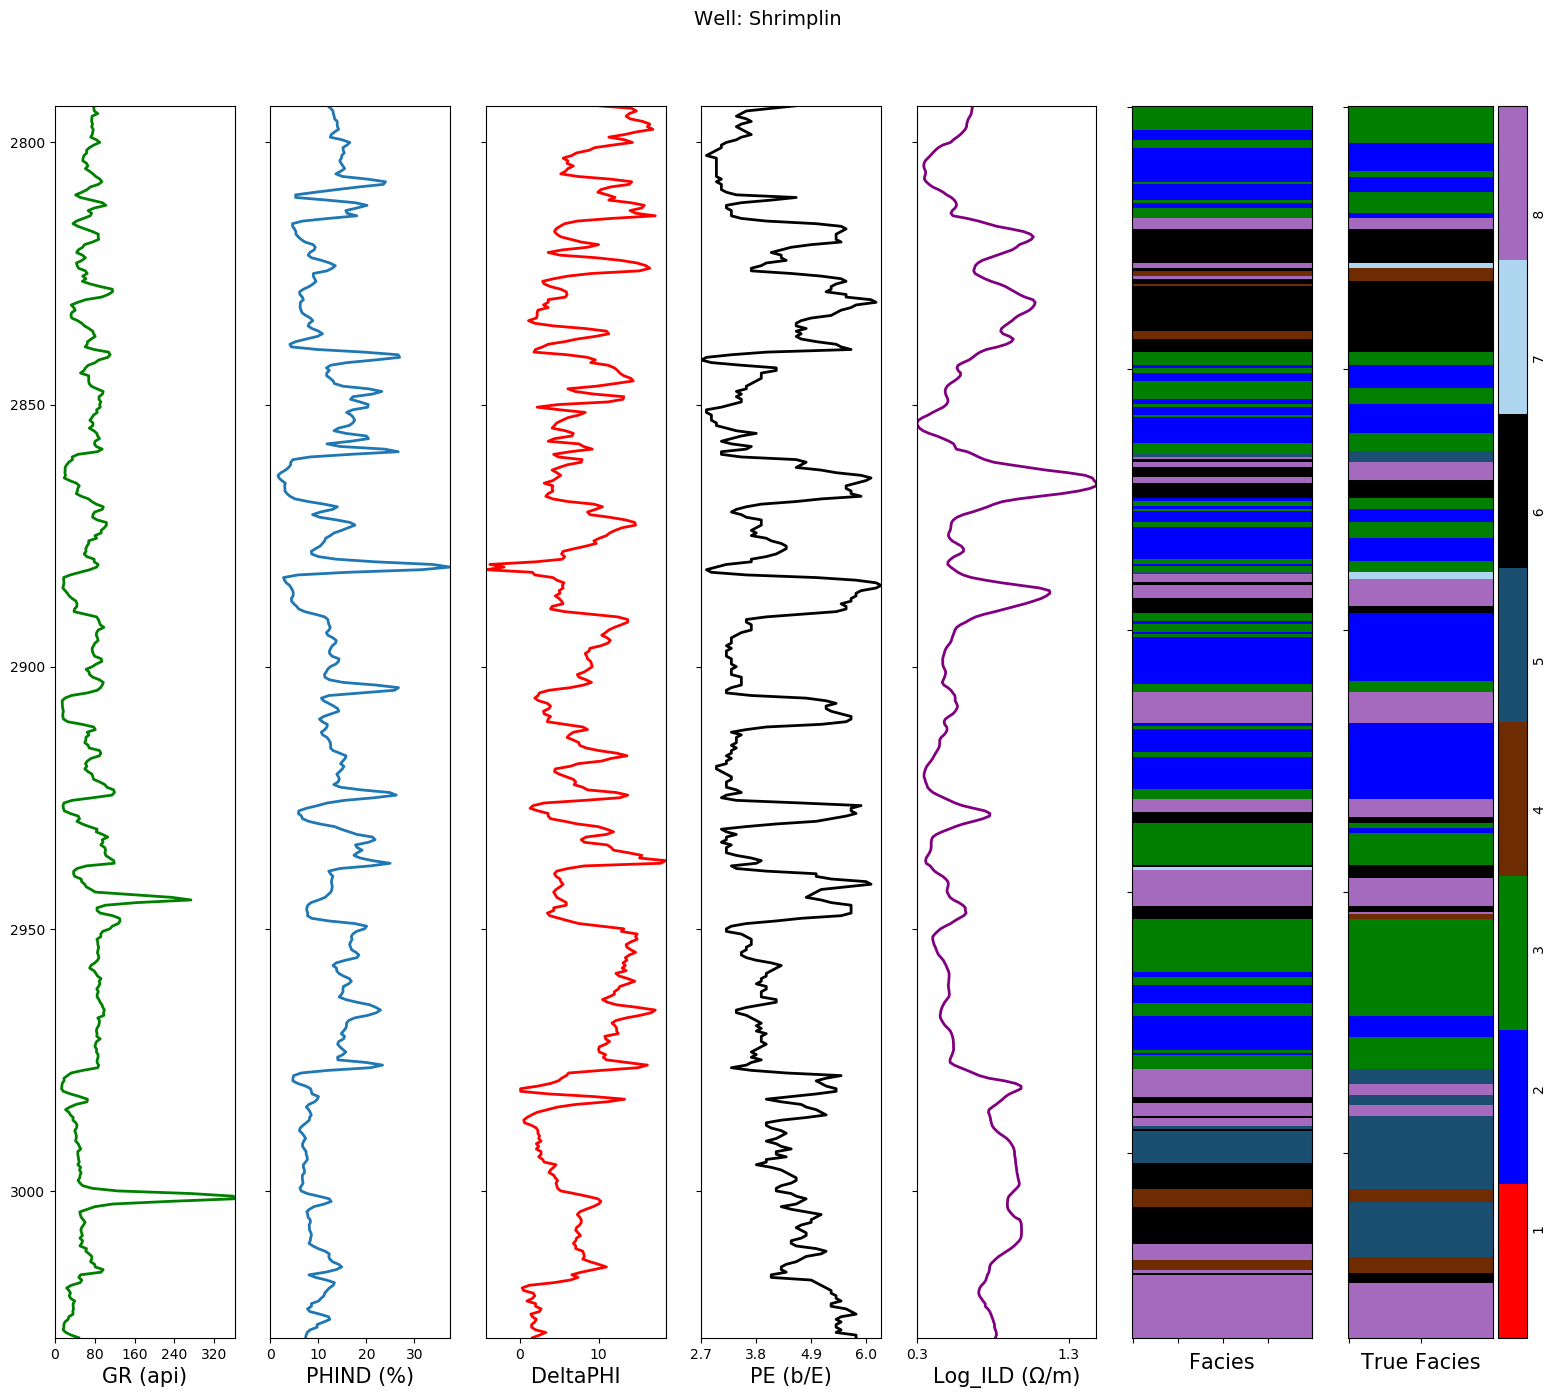

In [20]:
facies_colors = ['r', 'b','g','#6E2C00','#1B4F72','k', '#AED6F1', '#A569BD']

facies_labels = [0, 1, 2, 3, 4, 5, 6,7]

make_facies_log_plot(log_test,facies_colors)

In [21]:
log_test

,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Latitude,Longitude,pred_facies,Well_name
0,3,A1 SH,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,37.978076,-100.987305,3,Shrimplin
1,3,A1 SH,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,37.978076,-100.987305,3,Shrimplin
2,3,A1 SH,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,37.978076,-100.987305,3,Shrimplin
3,3,A1 SH,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,37.978076,-100.987305,3,Shrimplin
4,3,A1 SH,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,37.978076,-100.987305,3,Shrimplin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,8,C LM,3026.0,17.92,0.808,1.5,9.730,5.4,2,0.049,37.978076,-100.987305,9,Shrimplin
467,8,C LM,3026.5,16.51,0.814,2.0,8.275,5.5,2,0.039,37.978076,-100.987305,9,Shrimplin
468,8,C LM,3027.0,21.94,0.820,3.3,7.680,5.4,2,0.029,37.978076,-100.987305,9,Shrimplin
469,8,C LM,3027.5,32.54,0.821,2.5,7.445,5.8,2,0.020,37.978076,-100.987305,9,Shrimplin
